In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"D:\Jeeva\ds_course\employee_attrition\employee_attrition_cleaned.csv")

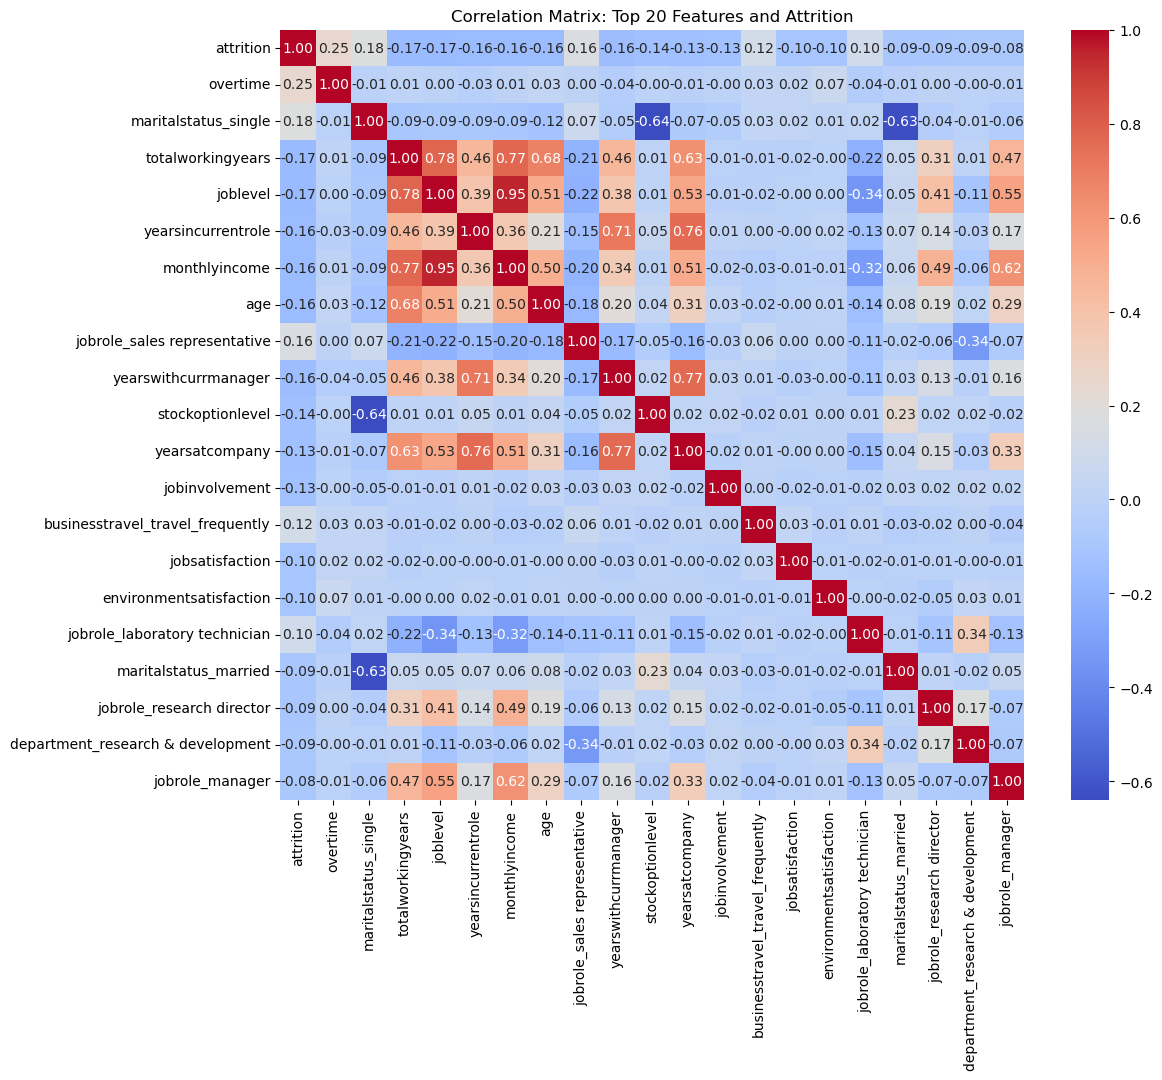

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top 20 features most correlated with 'attrition' (excluding itself)
top20_features = df.corr()['attrition'].abs().sort_values(ascending=False).iloc[1:21].index.tolist()

# Include 'attrition' itself to plot relationships with it
top20_features_with_attrition = ['attrition'] + top20_features

# Subset DataFrame
top20_df = df[top20_features_with_attrition]

# Compute correlation matrix
corr_matrix = top20_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix: Top 20 Features and Attrition')
plt.show()


['overtime', 'maritalstatus_single', 'totalworkingyears', 'joblevel', 'yearsincurrentrole', 'monthlyincome', 'age', 'jobrole_sales representative', 'yearswithcurrmanager', 'stockoptionlevel', 'yearsatcompany', 'jobinvolvement', 'businesstravel_travel_frequently', 'jobsatisfaction', 'environmentsatisfaction', 'jobrole_laboratory technician', 'maritalstatus_married', 'jobrole_research director', 'department_research & development']


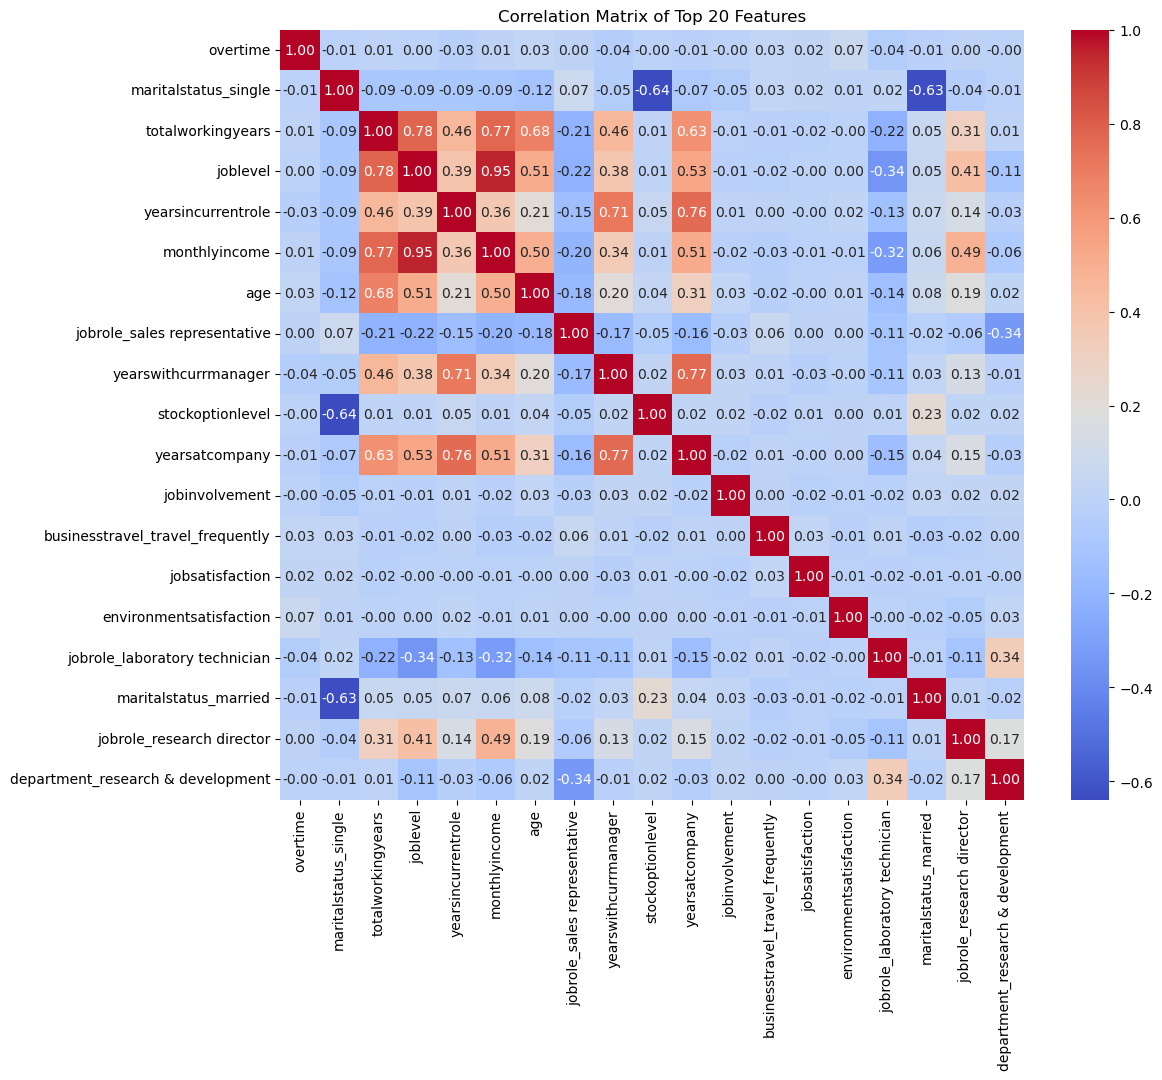

In [37]:
#checking direct corelation between selected 20 columns.
top_20_features = df.corr()['attrition'].abs().sort_values(ascending=False).iloc[1:20].index.tolist()
print(top_20_features)
corr_matrix = df[top_20_features].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 20 Features')
plt.show()

col_to_remove = ['totalworkingyears','joblevel','age','yearsatcompany','maritalstatus_married']

In [57]:
#remove correlated columns from top20 columns
col_to_remove = ['totalworkingyears','joblevel','age','yearsatcompany','maritalstatus_married']
top_15_features = [col for col in top_20_features if col not in col_to_remove]
print(top_15_features)

['overtime', 'maritalstatus_single', 'yearsincurrentrole', 'monthlyincome', 'jobrole_sales representative', 'yearswithcurrmanager', 'stockoptionlevel', 'jobinvolvement', 'businesstravel_travel_frequently', 'jobsatisfaction', 'environmentsatisfaction', 'jobrole_laboratory technician', 'jobrole_research director', 'department_research & development']


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  

top_15_features = ['overtime', 'maritalstatus_single', 'yearsincurrentrole', 'monthlyincome',
                   'jobrole_sales representative', 'yearswithcurrmanager', 'stockoptionlevel',
                   'jobinvolvement', 'businesstravel_travel_frequently', 'jobsatisfaction',
                   'environmentsatisfaction', 'jobrole_laboratory technician', 
                   'jobrole_research director', 'department_research & development']

# Split features and label
X = df[top_15_features]
y=df['attrition']

print(df['attrition'].value_counts())

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res,y_train_res = smote.fit_resample(X_train,y_train)

#fit model with training data
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res,y_train_res)

#predict
y_pred = dt.predict(X_test)

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix

print("accuracy: ",round(accuracy_score(y_test,y_pred) * 100,2)) 
print("precision: ",round(precision_score(y_test,y_pred) * 100,2))
print("recall: ",round(recall_score(y_test,y_pred) * 100,2))
print("f1_score: ",round(f1_score(y_test,y_pred) * 100,2))
print("auc_score: ",round(roc_auc_score(y_test,y_pred) * 100,2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3,5,10,20,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,5],
    'criterion':['gini','entropy']
}

grid_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid,scoring='f1',cv=5,n_jobs=-1)
grid_cv.fit(X_train, y_train)

best_model = grid_cv.best_estimator_
print(best_model)

from sklearn.model_selection import cross_val_score
f1_scores = cross_val_score(best_model,X_train,y_train,cv=5,scoring="f1")
print("Cross-validated F1 scores:", f1_scores)
print("Mean F1 Score:", round(f1_scores.mean() * 100, 2))

attrition
0    1233
1     237
Name: count, dtype: int64
accuracy:  74.49
precision:  30.56
recall:  46.81
f1_score:  36.97
auc_score:  63.28
Confusion Matrix:
 [[197  50]
 [ 25  22]]
DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
Cross-validated F1 scores: [0.41269841 0.43478261 0.38888889 0.30136986 0.4375    ]
Mean F1 Score: 39.5


In [3]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv(r"D:\Jeeva\ds_course\employee_attrition\employee_attrition_cleaned.csv")

# Split features and label
X = df.drop('attrition', axis=1)
y = df['attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reusable evaluation function
def evaluate_model(model, name):
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Evaluation")
    print("-" * 40)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Training Time: {end - start:.4f} seconds")

# Cross-validation function
def cross_validate_model(model, name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f"\n{name} Cross-Validation (5-Fold)")
    print("-" * 40)
    acc = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()
    prec = cross_val_score(model, X, y, cv=skf, scoring='precision').mean()
    rec = cross_val_score(model, X, y, cv=skf, scoring='recall').mean()
    f1 = cross_val_score(model, X, y, cv=skf, scoring='f1').mean()
    auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc').mean()
    
    print("Avg Accuracy:", acc)
    print("Avg Precision:", prec)
    print("Avg Recall:", rec)
    print("Avg F1 Score:", f1)
    print("Avg AUC-ROC:", auc)

# 1. Decision Tree
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
evaluate_model(dt, "Decision Tree")
cross_validate_model(dt, "Decision Tree")


Decision Tree Evaluation
----------------------------------------
Accuracy: 0.7993197278911565
Precision: 0.375
Recall: 0.3829787234042553
F1 Score: 0.37894736842105264
AUC-ROC: 0.6307606167628563
Confusion Matrix:
 [[217  30]
 [ 29  18]]
Training Time: 0.0094 seconds

Decision Tree Cross-Validation (5-Fold)
----------------------------------------
Avg Accuracy: 0.7802721088435375
Avg Precision: 0.3432597193466759
Avg Recall: 0.37597517730496455
Avg F1 Score: 0.3575548000442691
Avg AUC-ROC: 0.6170090165185828


In [11]:
# 2. Random Forest + GridSearch
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42,class_weight='balanced')
grid_rf = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Use best estimator
best_rf = grid_rf.best_estimator_
evaluate_model(best_rf, "Random Forest (Best Estimator)")
cross_validate_model(best_rf, "Random Forest (Best Estimator)")


Random Forest (Best Estimator) Evaluation
----------------------------------------
Accuracy: 0.8401360544217688
Precision: 0.5
Recall: 0.19148936170212766
F1 Score: 0.27692307692307694
AUC-ROC: 0.7812903781548799
Confusion Matrix:
 [[238   9]
 [ 38   9]]
Training Time: 0.5610 seconds

Random Forest (Best Estimator) Cross-Validation (5-Fold)
----------------------------------------
Avg Accuracy: 0.8612244897959183
Avg Precision: 0.706991341991342
Avg Recall: 0.25310283687943264
Avg F1 Score: 0.37081974125804035
Avg AUC-ROC: 0.8026737443918499


In [9]:
# 3. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model(xgb, "XGBoost")
cross_validate_model(xgb, "XGBoost")


C:\Users\JEEVA\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Evaluation
----------------------------------------
Accuracy: 0.8741496598639455
Precision: 0.7777777777777778
Recall: 0.2978723404255319
F1 Score: 0.4307692307692308
AUC-ROC: 0.7676802480833836
Confusion Matrix:
 [[243   4]
 [ 33  14]]
Training Time: 2.2162 seconds

XGBoost Cross-Validation (5-Fold)
----------------------------------------


C:\Users\JEEVA\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\JEEVA\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\JEEVA\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\JEEVA\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Avg Accuracy: 0.8571428571428571
Avg Precision: 0.628309483385884
Avg Recall: 0.3078014184397163
Avg F1 Score: 0.4099028667880923
Avg AUC-ROC: 0.800299377573843


performancerating
3    1244
4     226
Name: count, dtype: int64
--- Random Forest ---
Confusion Matrix:
 [[228  23]
 [ 38   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       251
           1       0.18      0.12      0.14        43

    accuracy                           0.79       294
   macro avg       0.52      0.51      0.51       294
weighted avg       0.76      0.79      0.77       294

ROC-AUC Score: 0.5051885481330493


CV F1 scores: [0.83333333 0.85185185 0.83076923 0.82901554 0.82162162]
Mean F1: 0.8333183163234977


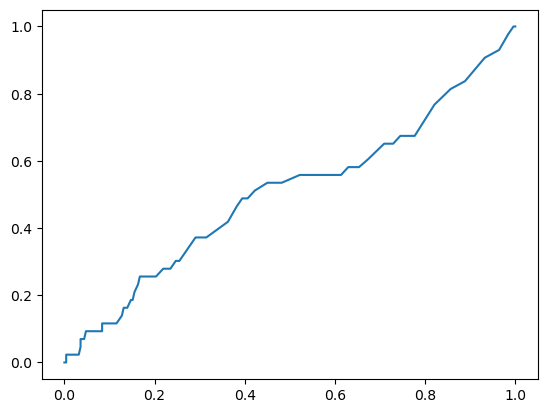

In [34]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns



df = pd.read_csv(r"D:\Jeeva\ds_course\employee_attrition\employee_attrition_cleaned.csv")


# Features and target
X = df[['education', 'jobinvolvement', 'joblevel', 'monthlyincome',
        'yearsatcompany', 'yearsincurrentrole']]
y = df['performancerating']

# Check class distribution
print(y.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train - y_train.min()
y_test = y_test - y_test.min()


# Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


rf = RandomForestClassifier(random_state=42,class_weight='balanced')
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # For ROC AUC

def evaluate_model(name, y_test, y_pred, y_prob):
    print(f"--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    if len(np.unique(y_test)) == 2:  # Binary only
        auc = roc_auc_score(y_test, y_prob)
        print("ROC-AUC Score:", auc)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    print("\n")

evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf)


from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_train_res, y_train_res, cv=cv, scoring='f1')
print("CV F1 scores:", scores)
print("Mean F1:", np.mean(scores))


In [32]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_train_res, y_train_res, cv=cv, scoring='f1')
print("CV F1 scores:", scores)
print("Mean F1:", np.mean(scores))


CV F1 scores: [0.83333333 0.85185185 0.83076923 0.82901554 0.82162162]
Mean F1: 0.8333183163234977


In [10]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # For ROC AUC


In [12]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]


In [14]:
def evaluate_model(name, y_test, y_pred, y_prob):
    print(f"--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    if len(np.unique(y_test)) == 2:  # Binary only
        auc = roc_auc_score(y_test, y_prob)
        print("ROC-AUC Score:", auc)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    print("\n")


--- Logistic Regression ---
Confusion Matrix:
 [[251   0]
 [ 43   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       251
           1       0.00      0.00      0.00        43

    accuracy                           0.85       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.73      0.85      0.79       294

ROC-AUC Score: 0.5875104234225887


--- Random Forest ---
Confusion Matrix:
 [[244   7]
 [ 42   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       251
           1       0.12      0.02      0.04        43

    accuracy                           0.83       294
   macro avg       0.49      0.50      0.47       294
weighted avg       0.75      0.83      0.78       294

ROC-AUC Score: 0.48466598721393495




C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NameError: name 'y_pred_xgb' is not defined

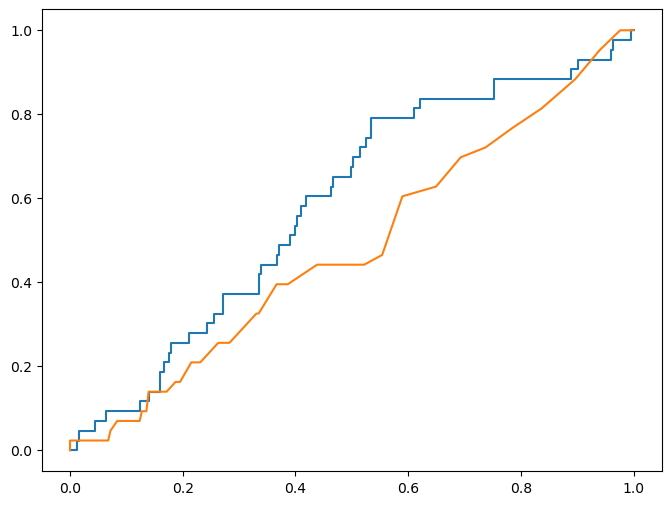

In [16]:
# === Plot ROC Curves ===
plt.figure(figsize=(8, 6))
evaluate_model("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_prob_xgb)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

performancerating
3    1244
4     226
Name: count, dtype: int64
--- Random Forest (Pipeline) ---
Confusion Matrix:
 [[231  18]
 [ 37   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       249
           1       0.31      0.18      0.23        45

    accuracy                           0.81       294
   macro avg       0.58      0.55      0.56       294
weighted avg       0.78      0.81      0.79       294

ROC-AUC Score: 0.541008478357876


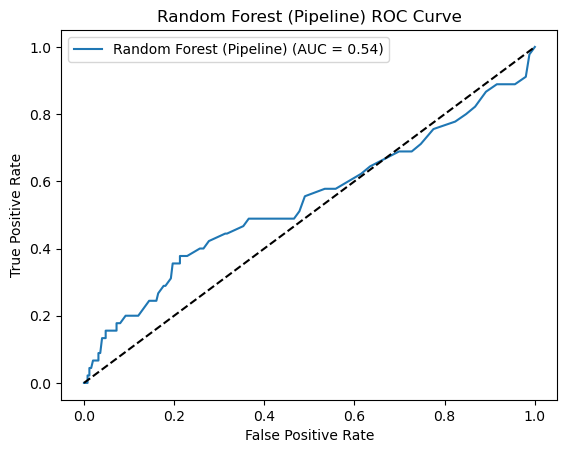

F1 Score: 0.22535211267605634


Cross-Validation F1 Scores: [0.16666667 0.12903226 0.09375    0.1        0.14545455]
Mean CV F1 Score: 0.12698069403714562


In [36]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv(r"D:\Jeeva\ds_course\employee_attrition\employee_attrition_cleaned.csv")

# Check class distribution
print(df['performancerating'].value_counts())

# Define features and target
X = df[['education', 'jobinvolvement', 'joblevel', 'monthlyincome',
        'yearsatcompany', 'yearsincurrentrole']]
y = df['performancerating']

# Label shift for binary classification (3 → 0, 4 → 1)
y = y - y.min()

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define pipeline with scaling, SMOTE, and classifier
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluation function
def evaluate_model(name, y_test, y_pred, y_prob):
    print(f"--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    if len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_prob)
        print("ROC-AUC Score:", auc)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} ROC Curve")
        plt.legend()
        plt.show()
    
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)
    print("\n")

# Evaluate on test set
evaluate_model("Random Forest (Pipeline)", y_test, y_pred, y_prob)

# Cross-validation on training data using the pipeline
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
print("Cross-Validation F1 Scores:", scores)
print("Mean CV F1 Score:", np.mean(scores))


Best Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       249
           1       0.16      0.18      0.17        45

    accuracy                           0.73       294
   macro avg       0.50      0.50      0.50       294
weighted avg       0.74      0.73      0.74       294

ROC-AUC Score: 0.5476126729138777


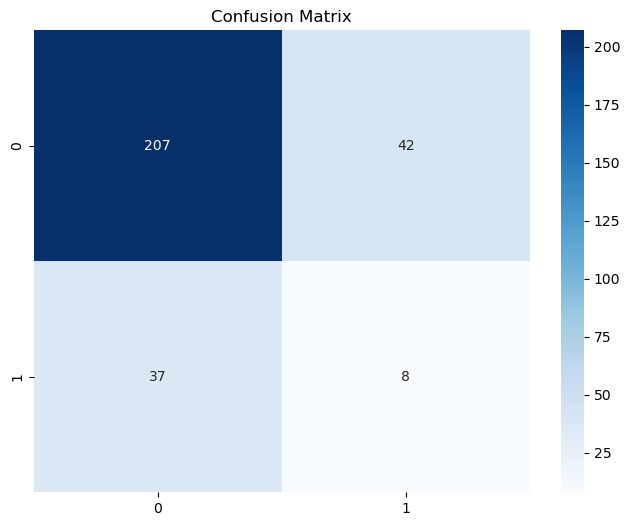

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv(r"D:\Jeeva\ds_course\employee_attrition\employee_attrition_cleaned.csv")

# Fix target encoding!
y = df['performancerating'].map({3: 0, 4: 1})

features = [
    'education', 'jobinvolvement', 'joblevel', 
    'monthlyincome', 'yearsatcompany', 'yearsincurrentrole'
]
X = df[features]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model + grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=3
)
rf.fit(X_train, y_train)
best_rf = rf.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters:", rf.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion matrix visualization
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
